<a href="https://colab.research.google.com/github/pacayton/forecast_combination_seminar/blob/main/Forecast_Combination_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecast Combination Using R**

### Peter Julian Cayton
### *Associate Professor, School of Statistics, University of the Philippines Diliman*

## Materials on GitHub:

https://github.com/pacayton/forecast_combination_seminar

## Contents:
1.   Basic Background
2.   Some Methods in Forecast Combination with Sample Codes
3.   References


Before we begin: 

1. Please load the data from GitHub to your Files folder in Google Colab
2. A preamble of code below

In [ ]:
install.packages("fpp3")
install.packages("fpp2")

library(fpp2)
library(fpp3)

COVID <- read.csv("/content/COVID_national_data.csv")
Monthly <- read.csv("/content/PhilMonthlyData.csv")
Quarterly <- read.csv("/content/PhilQuarterData.csv")

### 1. Basic Background

*   Combining forecasts from different models to improve predictive accuracy has long been known (Bates & Granger 1969; Clemen 1989).
*   Even simply averaging the forecasts from multiple models can improve accuracy greatly (Clemen 1989)
*   Recent use of forecast combinations have surged with the increase in computing power, the growth of data science, and forecasting competitions (Makridakis, Spiliotis, & Assimakopoulos 2020). 
*   More recently, forecast combination methods have been called "ensemble forecasting" but they are essentially similar in terms of combining forecasts from different model configurations.
*   With COVID-19, forecast ensembles have been used for cases, deaths, and hospitalizations in the US (Ray, et al. 2020) and for deaths in multiple countries (Imperial College COVID-19 response team 2022)



### 2. Some Methods in Forecast Combination with Sample Codes

#### 1. Simple Average/Equal Weights Method

> This means averaging the forecasts from different models for the horizon with equal weights






Sample Code in R based on FPP2 (Hyndman & Athanasopoulos 2018) applied to Philippine nonagri data

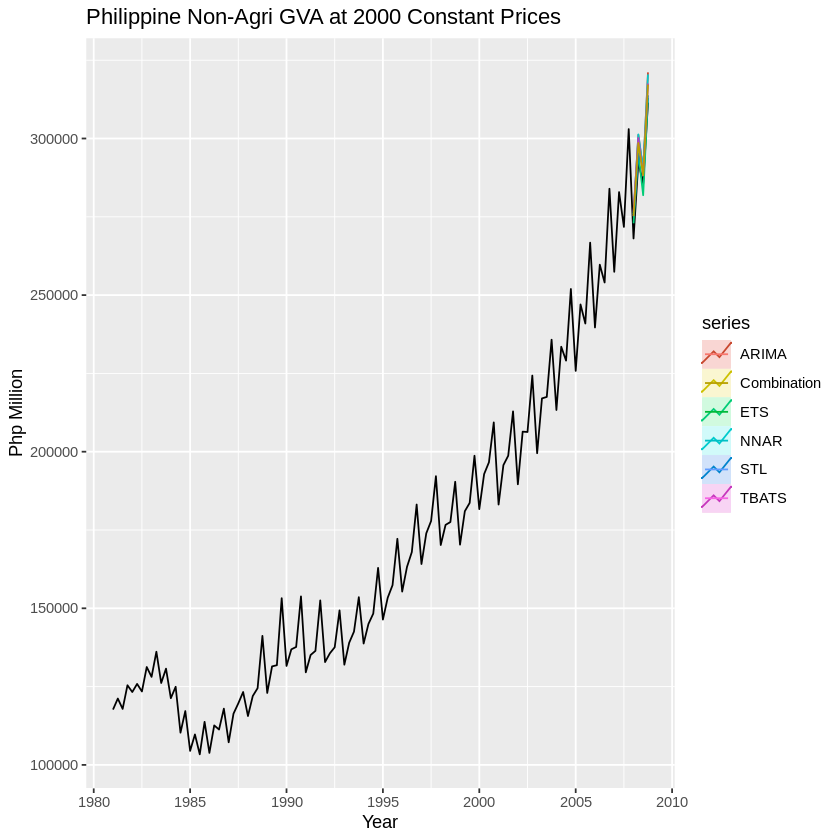

In [41]:
### Extract Philippine nonagri Data from Quarterly file
nonagri <- ts(Quarterly$nonagri, start = c(1981, 1), frequency = 4)

### Train Data
nonagri.train <- window(nonagri, end = c(2007, 4))

### Forecast Horizon
h <- length(nonagri) - length(nonagri.train)

### The five models as example
ETS <- forecast(ets(nonagri.train), h=h)
ARIMA <- forecast(auto.arima(nonagri.train),h=h)
STL <- stlf(nonagri.train, h=h)
NNAR <- forecast(nnetar(nonagri.train), h=h)
TBATS <- forecast(tbats(nonagri.train), h=h)

### Combining the forecasts
Combination <- (ETS[["mean"]] + ARIMA[["mean"]] +
  STL[["mean"]] + NNAR[["mean"]] + TBATS[["mean"]])/5

### Plot of the Forecasts
autoplot(nonagri) +
  autolayer(ETS, series="ETS", PI=FALSE) +
  autolayer(ARIMA, series="ARIMA", PI=FALSE) +
  autolayer(STL, series="STL", PI=FALSE) +
  autolayer(NNAR, series="NNAR", PI=FALSE) +
  autolayer(TBATS, series="TBATS", PI=FALSE) +
  autolayer(Combination, series="Combination") +
  xlab("Year") + ylab("Php Million") +
  ggtitle("Philippine Non-Agri GVA at 2000 Constant Prices")


In [42]:
### Accuracy Statistics between Methods

c(ETS = accuracy(ETS, nonagri)["Test set","RMSE"],
  ARIMA = accuracy(ARIMA, nonagri)["Test set","RMSE"],
  `STL-ETS` = accuracy(STL, nonagri)["Test set","RMSE"],
  NNAR = accuracy(NNAR, nonagri)["Test set","RMSE"],
  TBATS = accuracy(TBATS, nonagri)["Test set","RMSE"],
  Combination =
    accuracy(Combination, nonagri)["Test set","RMSE"])


ETS       ARIMA     STL-ETS        NNAR       TBATS Combination 
   3403.990    7709.409    4819.353    7739.355    6613.690    5622.664

Sample Code in R based on FPP2 (Hyndman & Athanasopoulos 2018) applied to Philippine COVID data

ARIMA        NNAR       TBATS Combination 
  1997.7470   1795.4865    694.7894   1441.9692

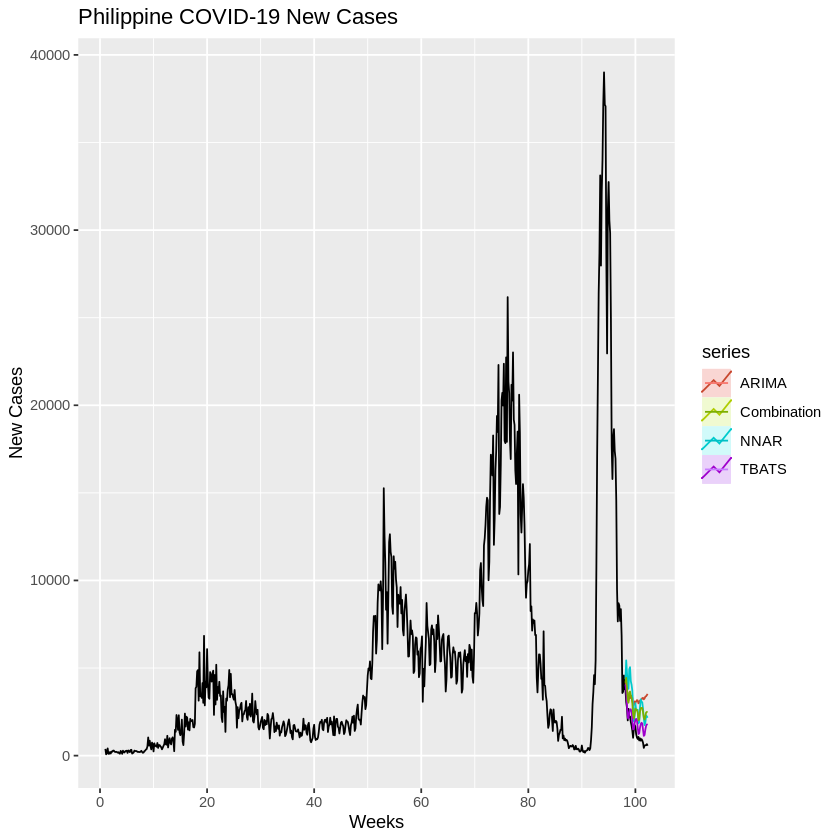

In [39]:
### Extract Philippine COVID Data from file
covid.inc <- ts(COVID$New_Cases, frequency = 7)
## Frequency = 7 is for weekly seasonality

### Forecast Horizon
h <- 30

### Train Data
covid.train <- head(covid.inc, length(covid.inc)-h )

### The three models as example
ARIMA <- forecast(auto.arima(covid.train, lambda=0, biasadj=TRUE),
  h=h)
NNAR <- forecast(nnetar(covid.train), h=h)
TBATS <- forecast(tbats(covid.train, biasadj=TRUE), h=h)

### Combining the forecasts
Combination <- (ARIMA[["mean"]] + NNAR[["mean"]] + TBATS[["mean"]])/3

### Plot of the Forecasts
autoplot(covid.inc) +
  autolayer(ARIMA, series="ARIMA", PI=FALSE) +
  autolayer(NNAR, series="NNAR", PI=FALSE) +
  autolayer(TBATS, series="TBATS", PI=FALSE) +
  autolayer(Combination, series="Combination") +
  xlab("Weeks") + ylab("New Cases") +
  ggtitle("Philippine COVID-19 New Cases")

### Accuracy Statistics between Methods
c(ARIMA = accuracy(ARIMA, covid.inc)["Test set","RMSE"],
  NNAR = accuracy(NNAR, covid.inc)["Test set","RMSE"],
  TBATS = accuracy(TBATS, covid.inc)["Test set","RMSE"],
  Combination = accuracy(Combination, covid.inc)["Test set","RMSE"])

Sample Code in R based on FPP2 (Hyndman & Athanasopoulos 2018) applied to MRT3 Total Passenger data

ETS       ARIMA     STL-ETS        NNAR       TBATS Combination 
  1.3048333   1.1379599   1.3270450   0.6189480   0.4719119   0.8876797

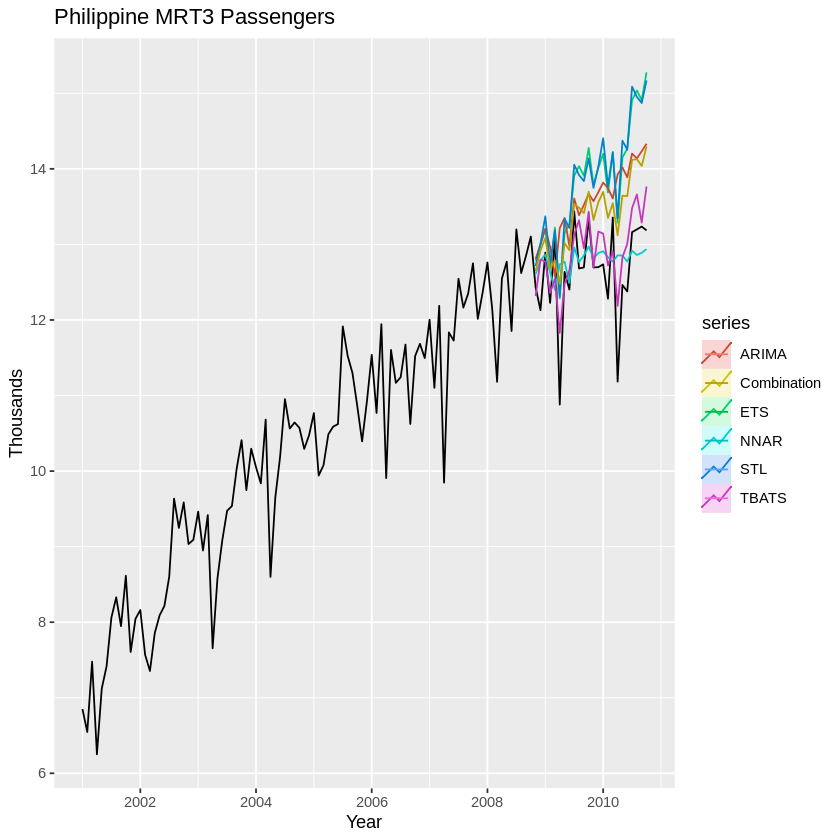

In [43]:
### Extract Philippine COVID Data from file
mrt3 <- ts(na.omit(Monthly$mrt3), frequency = 12, start = c(2001,1))


### Forecast Horizon
h <- 24

### Train Data
mrt3.train <- head(mrt3, length(mrt3)-h )


### The five models as example
ETS <- forecast(ets(mrt3.train ), h=h)
ARIMA <- forecast(auto.arima(mrt3.train),
  h=h)
STL <- stlf(mrt3.train, h=h)
NNAR <- forecast(nnetar(mrt3.train), h=h)
TBATS <- forecast(tbats(mrt3.train), h=h)

### Combining the forecasts
Combination <- (ETS[["mean"]] + ARIMA[["mean"]] +
  STL[["mean"]] + NNAR[["mean"]] + TBATS[["mean"]])/5

### Plot of the Forecasts
autoplot(mrt3) +
  autolayer(ETS, series="ETS", PI=FALSE) +
  autolayer(ARIMA, series="ARIMA", PI=FALSE) +
  autolayer(STL, series="STL", PI=FALSE) +
  autolayer(NNAR, series="NNAR", PI=FALSE) +
  autolayer(TBATS, series="TBATS", PI=FALSE) +
  autolayer(Combination, series="Combination") +
  xlab("Year") + ylab("Thousands") +
  ggtitle("Philippine MRT3 Passengers")

### Accuracy Statistics between Methods

c(ETS = accuracy(ETS, mrt3)["Test set","RMSE"],
  ARIMA = accuracy(ARIMA, mrt3)["Test set","RMSE"],
  `STL-ETS` = accuracy(STL, mrt3)["Test set","RMSE"],
  NNAR = accuracy(NNAR, mrt3)["Test set","RMSE"],
  TBATS = accuracy(TBATS, mrt3)["Test set","RMSE"],
  Combination = accuracy(Combination, mrt3)["Test set","RMSE"])

#### 2. Inverse Residual Variance Method

> The method with the lowest residual/error variance gets to have larger weights in the forecast combination approach


Using the same examples, but shifting to use a similar scheme from FPP3 (Hyndman & Athanasopoulos 2021) with fabletools (O'Hara-Wild, et al. 2021).

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arima,Test,6414.782,6733.882,6414.782,2.252296,2.252296,0.8416573,0.7583970,-0.3326077
ets,Test,6945.403,7227.507,6945.403,2.437142,2.437142,0.9112779,0.8139910,-0.1493745
cmbn1,Test,7095.769,7466.909,7095.769,2.480572,2.480572,0.9310068,0.8409534,-0.4164680
stlf,Test,8560.669,9510.008,8560.669,2.960606,2.960606,1.1232104,1.0710556,-0.6893689


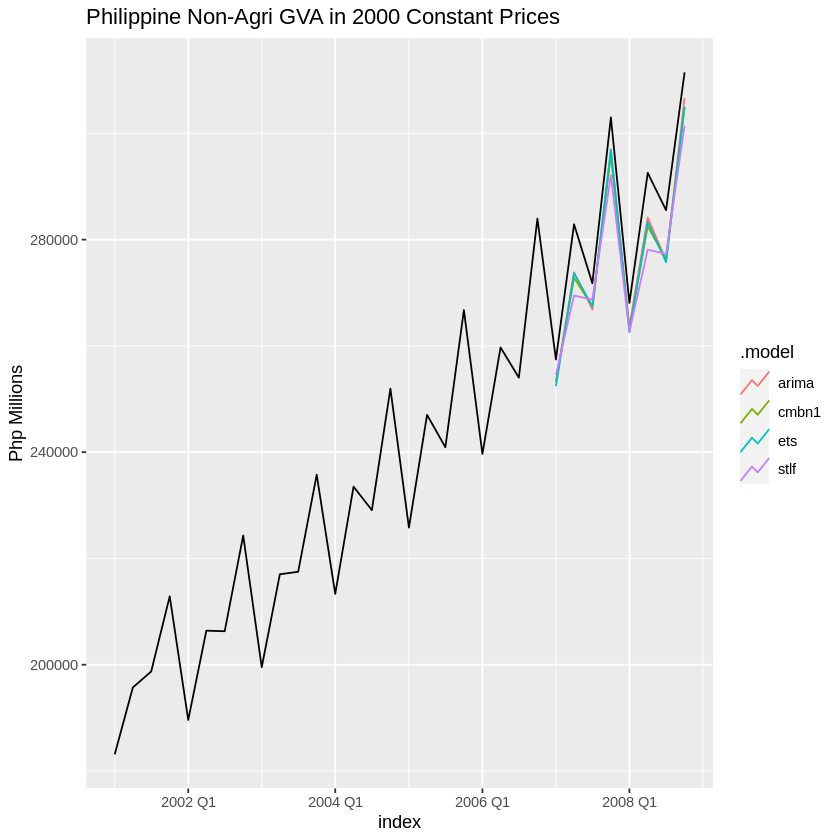

In [64]:
## Quick Conversion from ts to tsibble
nonagri.tsb <- nonagri %>% as_tsibble()


## Train Data
nonagri.tsb.train <- nonagri.tsb %>% filter(year(index) <= 2006)


## Setting up the Forecasting Model for STL
STLF <- decomposition_model(
  STL(log(value) ~ season(window = Inf)),
  ETS(season_adjust ~ season("N"))
)

### Estimating 3 models and their combination
nonagri_models <- nonagri.tsb.train %>%
  model(
    ets = ETS(value),
    stlf = STLF,
    arima = ARIMA(log(value)),
    cmbn1 = combination_model(
      ETS(value), STLF, ARIMA(log(value)), 
      cmbn_args = list(weights = "inv_var")
      )
  )

### Forecast for 2 years
nonagri_fc <- nonagri_models %>%
  forecast(h = "2 years")

### Plot forecasts
nonagri_fc %>%
  autoplot(nonagri.tsb %>% filter(year(index) > 2000), level = NULL) +
  labs(y = "Php Millions",
    title = "Philippine Non-Agri GVA in 2000 Constant Prices")


### Test Accuracy Measures
nonagri_fc %>% accuracy(nonagri.tsb) %>% arrange(RMSE)

In [68]:
### Quick Conversion of ts to tsibble
### PS: Ignore the dates for the meantime: they were complicated to deal
covid.tsb <- covid.inc %>% as_tsibble()



### 3. References:

1. Bates, J. M., & Granger, C. W. J. (1969). The combination of forecasts. Operational Research Quarterly, 20(4), 451–468. https://www.tandfonline.com/doi/abs/10.1057/jors.1969.103

2. Clemen, R. (1989). Combining forecasts: A review and annotated bibliography. International Journal of Forecasting, 5(4), 559–583. https://www.sciencedirect.com/science/article/abs/pii/0169207089900125

3. Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 2022-03-01.

4. Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on 2022-03-01.

5.  Imperial College COVID-19 response team (2022). Short-term forecasts of COVID-19 deaths in multiple countries. https://mrc-ide.github.io/covid19-short-term-forecasts/. Accessed last 2022-03-09.

6. Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2020). The M4 Competition: 100,000 time series and 61 forecasting methods. International Journal of Forecasting. Volume 36, Issue 1, January–March 2020, Pages 54-74. https://doi.org/10.1016/j.ijforecast.2019.04.014

7. O'Hara-Wild, M., Hyndman, R., & Wang, E. (2021). fabletools: Core Tools for Packages in the 'fable' Framework. R package version 0.3.2. https://CRAN.R-project.org/package=fabletools

8. Ray, et al. (2020). Ensemble Forecasts of Coronavirus Disease 2019 (COVID-19) in the U.S. medRxiv. DOI: https://doi.org/10.1101/2020.08.19.20177493.